# Laboratorium 1
## Zadanie 1

In [1]:
from math import exp, pi

In [2]:
def linear_rng(last_x, m, a_0, a_1):
    last_x = (last_x * a_1 + a_0) % m
    return last_x

def linear_generator(
        seed=123,
        k = 1,
        a_0 = (exp(1) * 1e9)//1,
        a_1 = (pi * 1e9)//1, 
        m = 2 ** 35
    ):
    last_x = linear_rng(seed, m, a_0, a_1)      
    while True:
        yield last_x/(m-1)
        last_x = linear_rng(last_x, m, a_0, a_1)

def sample_rng(count, generator, **kwargs):
    return [el for _, el in zip(range(count), generator(**kwargs))]

In [3]:
sample_rng(10, linear_generator, seed=123)

[0.3252951457201647,
 0.9004038572573453,
 0.6893234253130307,
 0.5202975273283751,
 0.2604303360061147,
 0.27043187619042675,
 0.4312365055209735,
 0.48976778985495234,
 0.3186981678101787,
 0.5669914484189064]

In [4]:
import matplotlib.pyplot as plt

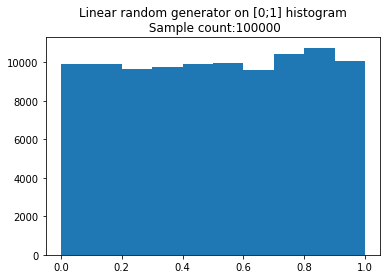

In [5]:
sample_count = 100000
plt.hist(
    sample_rng(sample_count, linear_generator, seed=123)
)
plt.title(f"Linear random generator on [0;1] histogram\n Sample count:{sample_count}")
plt.show()

## Zadanie 2


### Gęstości 

In [6]:
import numpy as np
from scipy.stats import norm, uniform

In [7]:
def density(x):
    return (
        ( (1 + np.cos(2*pi*x)) * np.exp(-x**2/2) ) /
        ( (1 + np.exp(-2 * pi**2)) * np.sqrt(2*pi) )
    )

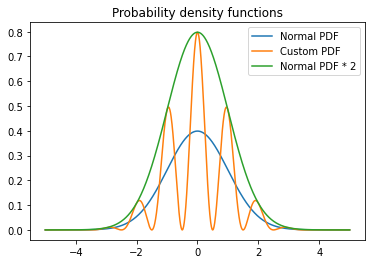

In [8]:
space = np.linspace(-5, 5, 1000)
normal = norm.pdf(space)
modified = density(space)
plt.plot(space, normal)
plt.plot(space, modified)
plt.plot(space, normal * 2)
plt.title("Probability density functions")
plt.legend([
    "Normal PDF",
    "Custom PDF",
    "Normal PDF * 2"
])
plt.show()

### Generator Metody Eliminacji

In [9]:
from scipy.stats import norm, uniform
from random import gauss as gauss_builtin_rng, random as uniform_bulitin_rng

def EM_rng(f_density, a):
    x = gauss_builtin_rng(0, 1)
    y = uniform_bulitin_rng()
    while y > f_density(x)/(a*norm.pdf(x)):
        x = gauss_builtin_rng(0, 1)
        y = uniform_bulitin_rng()
    return x

In [10]:
EM_rng(density, 2)

0.9773230983842681

### Test kompilacji Just-In-Time z `numba`
Od pewnego czasu miałem ochotę przetestować pakiet `numba`. 
Funkcja generująca 100 tyś. próbek zajmuje sporo czasu, bo jest napisana głównie w Pythonie, bez pomocy `numpy`.
Musiałem ręcznie wklepać gęstość normalną (`scipy` dziwnie nimi zarządza), ale poza tym nie wprowadzałem żadnych zmian w kod.

In [11]:
# %pip install numba

In [12]:
from numba import njit # nopython jit

@njit
def norm_pdf(x): # numba gryzie się z scipy
    return (
        (np.exp(-x**2/2)) 
        / 
        (np.sqrt(2*pi))
    )

@njit
def density_jit(x):
    return (
        ( (1 + np.cos(2*pi*x)) * np.exp(-x**2/2) ) 
        /
        ( (1 + np.exp(-2 * pi**2)) * np.sqrt(2*pi) )
    )

@njit
def EM_rng_jit(f_density, a):
    x = gauss_builtin_rng(0, 1)
    y = uniform_bulitin_rng()
    while y > f_density(x)/(a*norm_pdf(x)):
        x = gauss_builtin_rng(0, 1)
        y = uniform_bulitin_rng()
    return x

In [13]:
EM_rng_jit(density_jit, 2)

0.9568434905611007

In [14]:
sample_count = 100000

In [19]:
%%time
EM_sample = [EM_rng(density, 2) for _ in range(sample_count)]

CPU times: user 28.7 s, sys: 92.7 ms, total: 28.8 s
Wall time: 28.7 s


In [20]:
%%time
EM_sample = [EM_rng_jit(density_jit, 2) for _ in range(sample_count)]

CPU times: user 954 ms, sys: 0 ns, total: 954 ms
Wall time: 955 ms


Efekty mówią same za siebie, w zależności od uruchomienia próbka generuje się 25-30 razy szybciej z wykorzystaniem kompilatora JIT.

### Porównanie z teoretyczną gęstością

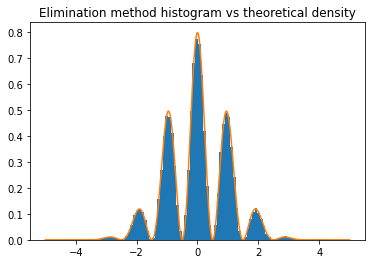

In [22]:
plt.hist(
    EM_sample,
    bins=100,
    density=True
)
plt.plot(space, modified)
plt.title("Elimination method histogram vs theoretical density")
plt.show()

## Zadanie 3
Generacja rozkładu Poissona $ P \sim Pois(\lambda) $


### Metoda 1: Konstrukcja
Niech $(X_n)_{n \in \mathbb{N}}$ taki, że $X_i$ iid, oraz $X_i \sim EXP(\lambda') \ \forall_i$.

Wtedy $N_t = \max \{n: X_1 + ... + X_n \le t\}$ to process Poissona, który ma rozkład $ N_t \sim Pois(\lambda' t)$

#### Odwrócenie $EXP(\lambda)$
Niech $ X \sim EXP(\lambda) $.

Wtedy $ F_X(x) = 1 - e^{-\lambda x}$

$ 1 - F_X(x) = e^{-\lambda x}$

$ \ln(1 - F_X(x)) = -\lambda x$

$ -\frac{\ln(1 - F_X(x))}{\lambda} = x$

Zatem $F_X^{-1}(x) = -\frac{\ln(1 - x)}{\lambda} $

In [61]:
def to_exp(x, l):
    return -np.log(1-x)/l

def exp_rng(l):
    return to_exp(uniform_bulitin_rng(), l)

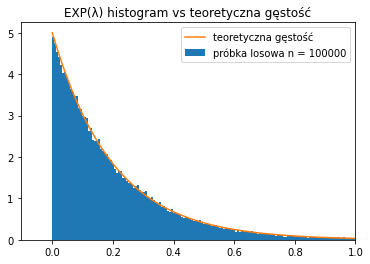

In [117]:
# Sanity check
from scipy.stats import expon as exp_dist
rate = 5
plt.hist(
    [to_exp(uniform_bulitin_rng(), rate) for _ in range(sample_count)],
    bins = int(np.sqrt(sample_count)),
    density = True,
)
plt.plot(
    np.linspace(0, 2, 1000),
    exp_dist.pdf(
        np.linspace(0, 2, 1000),
        scale=1/rate # scale = 1 / rate, my definiujemy po rate
    ) 
)
plt.xlim(right=1)
plt.title("EXP(λ) histogram vs teoretyczna gęstość")
plt.legend(["teoretyczna gęstość", f"próbka losowa n = {sample_count}"])
plt.show()

#### Konstrukcja
Można ustalić $t$ dowolne dodatnie, wtedy $\lambda' = \frac{ \lambda } {t}$. Tym możemy sterować dokładność (?).

In [59]:
#TODO: ^

In [71]:
def poisson_proc(t, l):
    Nt = 0
    lprim = l / t
    sum_so_far = 0
    while sum_so_far <= t:
        sum_so_far += exp_rng(lprim)
        Nt += 1
    # Następny skok przekroczył, czyli jesteśmy o 1 za daleko
    Nt -= 1
    return Nt

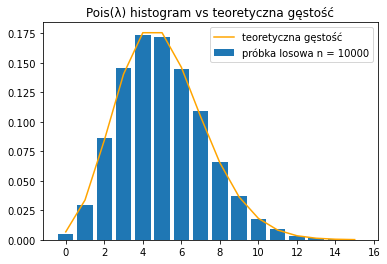

In [173]:
from scipy.stats import poisson
sample_small = 10000

poisson_sample = [poisson_proc(5, rate) for _ in range(sample_small)]
counts = Counter(poisson_sample).items()

rate = 5
plt.bar(
    [i for i, _ in counts],
    [i/sample_small for _, i in counts],
    #bins=int(np.sqrt(sample_small)),
    #density = True,
)
plt.plot(
    np.linspace(0, 15, 16),
    poisson.pmf(
        np.linspace(0, 15, 16),
        mu=rate 
    ),
    color="orange"
)
#plt.xlim(right=1)
plt.title("Pois(λ) histogram vs teoretyczna gęstość")
plt.legend(["teoretyczna gęstość", f"próbka losowa n = {sample_small}"])
plt.show()

In [161]:
sorted(list(Counter(poisson_sample).items()))

[(0, 3),
 (1, 36),
 (2, 86),
 (3, 148),
 (4, 170),
 (5, 177),
 (6, 144),
 (7, 107),
 (8, 66),
 (9, 32),
 (10, 22),
 (11, 3),
 (12, 4),
 (13, 2)]

### Metoda 2: ???